### Import the Dataset

In [1]:
# import common libraries
import math
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# import lifetime packages
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes import ModifiedBetaGeoFitter
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
from lifetimes.plotting import plot_history_alive
from lifetimes.plotting import plot_expected_repeat_purchases
from lifetimes.plotting import plot_cumulative_transactions
from lifetimes.plotting import plot_transaction_rate_heterogeneity
from lifetimes.plotting import plot_dropout_rate_heterogeneity
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.datasets import load_cdnow_summary_data_with_monetary_value
from lifetimes.generate_data import modified_beta_geometric_nbd_model

In [2]:
# import data
data = pd.read_csv('data-science-exercise-data.csv')

In [3]:
# make a copy of the original data
df = data

In [4]:
# check basic info
df.head()

,CustomerID,Timestamp,PurchaseValue
0,5611860a94204a4078659f1667372cc4,2017-02-09T18:31:00Z,4.72
1,07b260307114f9cffc5601eb7ad4b565,2017-06-28T19:26:00Z,5.33
2,1ede55062d0d68c70fc4d355a5328d11,2017-07-28T17:47:00Z,5.35
3,42b8e86e8da5e35628bcdc146c358665,2016-12-17T22:59:00Z,6.00
4,1047f2787b7efc759d7ffcbc40ef7e19,2016-12-05T17:23:00Z,6.28


In [5]:
# check basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49945 entries, 0 to 49944
Data columns (total 3 columns):
CustomerID       49945 non-null object
Timestamp        49945 non-null object
PurchaseValue    49945 non-null float64
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


In [6]:
# check stats
df.describe()

,PurchaseValue
count,49945.000000
mean,236.888196
std,245.760987
min,4.720000
25%,97.100000
50%,166.660000
75%,286.790000
max,11599.680000


In [7]:
# change the date attribute from object to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

### Exploratory Data Analysis

In [8]:
# total number of transactions 
df.shape

(49945, 3)

In [9]:
# number of customers : 
df.groupby(['CustomerID']).size().shape

(23708,)

In [10]:
# date range of the dataset:
print("begin: ", df['Timestamp'].min())
print("end: ", df['Timestamp'].max())

begin:  2016-11-30 04:47:00
end:  2017-12-06 17:53:00


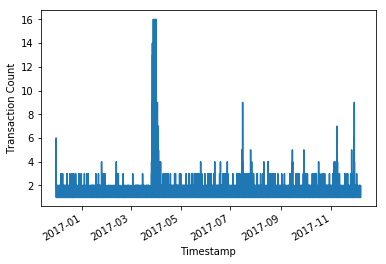

In [11]:
# Time series of the number of transactions (daily)
ts_transactions = df.groupby(['Timestamp']).size()
plt.ylabel('Transaction Count')
ts_transactions.plot()

As we can see from the graph, the transaction count has seasonality. There are four peaks of transaction count with the highest time around 2017-04.

In [12]:
# let's take a look at the typical inter-purchase time and IPT distribution.
def shift_date(x): 
    x['shifted_date'] = x['Timestamp'].shift(-1) 
    return x

# We'll apply a shift of -1 between the 'date' column and a newly shifted date column shift_date. 
# That way, we'll be able to subtract date from shifted_date at the customer level and compute 
# the inter purchase time (IPT) directly : 
transactions_tmp = df.sort_values(['Timestamp']).\
                        groupby(['CustomerID'], as_index=True).apply(shift_date)    

# let's re-order by customer and date : 
transactions_tmp.sort_values(['CustomerID','Timestamp'], ascending=True, inplace=True)
transactions_tmp.dropna(inplace=True)

# compute the IPT in days : 
transactions_tmp['IPT'] = (transactions_tmp['shifted_date'] - transactions_tmp['Timestamp']).apply(lambda x : x.days)

transactions_tmp.head(5)

,CustomerID,Timestamp,PurchaseValue,shifted_date,IPT
10498,0001117ff1305c1fe840697166e61564,2016-12-27 21:05:00,88.25,2017-01-07 15:14:00,10
5047,0003f3458a6e7b495a975c2d9ddda559,2016-12-28 22:14:00,68.28,2016-12-30 19:00:00,1
6838,0003f3458a6e7b495a975c2d9ddda559,2016-12-30 19:00:00,76.63,2017-10-09 20:26:00,283
39914,0008e6b90a8f191089e8a0757fabf968,2017-09-20 14:57:00,323.95,2017-11-28 20:35:00,69
5640,00090b9fa28029c4839ca0a0306b6b11,2017-09-15 04:02:00,69.44,2017-11-15 02:22:00,60


In [13]:
# let's print the mean IPT. Our training period of 365 days is long enough. 
transactions_tmp['IPT'].mean()

52.24575980485574

(0, 270)

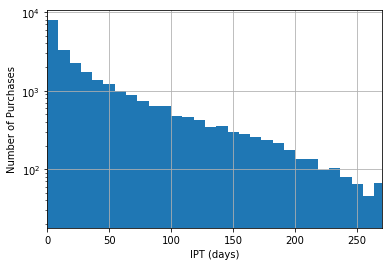

In [14]:
# distribution of IPT : 
transactions_tmp['IPT'].hist(bins=40)
plt.yscale('log')
plt.xlabel('IPT (days)') 
plt.ylabel('Number of Purchases') 

# 275 (365-90) days to avoid right censorship issues. 
plt.xlim([0,270])

Minimum of Purchases:  1
Maximum of Purchases:  135


Text(0,0.5,'Number of Customers')

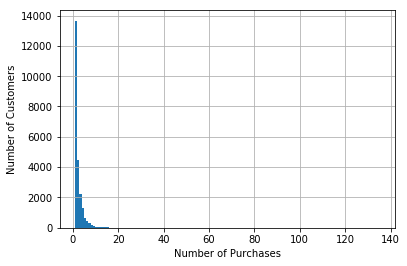

In [15]:
# Let's look at the distribution of the number of purchases per customer : 

n_purchases = df.groupby(['CustomerID']).size()
print("Minimum of Purchases: ", n_purchases.min(axis=0))
print("Maximum of Purchases: ", n_purchases.max(axis=0))
n_purchases.hist(bins=((n_purchases.max(axis=0) - n_purchases.min(axis=0)) + 1))
plt.xlabel('Number of Purchases')
plt.ylabel('Number of Customers')

Text(0,0.5,'Number of Customers')

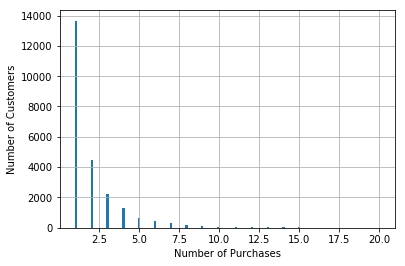

In [16]:
# scale the graph to get more accurate information
n_purchases.hist(bins=((n_purchases.max(axis=0) - n_purchases.min(axis=0)) + 1), range=(1,20))
plt.xlabel('Number of Purchases')
plt.ylabel('Number of Customers')

We can see that more than 54% (13000 / 23708) only made a single purchase in the 1 year period covered by the dataset.

### 1. Modified BG Model Implementation
###### Implement the modified BG model from the lifetimes package using the data we provide.

###### Compute RFM dataframe
We will resample the original dataset to get recency-frequency-monetary value (RFM) object.
* Recency: the number of days between first and last purchase 
* Frequency: repeat frequency during the observation period, i.e. the number of purchases beyond the initial one (repeat frequency = purchase counts - 1)
* Monetary Value : mean of all the transactions in the observation period
* T : time between first purchase and end of observation period

In [17]:
# use the library method from the lifetimes package
summary = summary_data_from_transaction_data(df, 'CustomerID', 'Timestamp', monetary_value_col='PurchaseValue')

In [18]:
# summary info
summary.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
0001117ff1305c1fe840697166e61564,1.0,11.0,344.0,87.280
00028502859fd7e111d88c20456b59d5,0.0,0.0,342.0,0.000
000306d200fd6e9b03de48d15348f5c2,0.0,0.0,33.0,0.000
0003f3458a6e7b495a975c2d9ddda559,2.0,285.0,343.0,88.065
000784b838b807ad589d4bc69c0c562f,0.0,0.0,210.0,0.000


In [19]:
# summary info for Customer '0003f3458a6e7b495a975c2d9ddda559'
print(summary.loc['0003f3458a6e7b495a975c2d9ddda559'])

print('-------------------------------------------------------------------')

# original info for Customer '0003f3458a6e7b495a975c2d9ddda559'
df_check = df.set_index(["CustomerID"])
print(df_check.loc['0003f3458a6e7b495a975c2d9ddda559'])

frequency           2.000
recency           285.000
T                 343.000
monetary_value     88.065
Name: 0003f3458a6e7b495a975c2d9ddda559, dtype: float64
-------------------------------------------------------------------
                                           Timestamp  PurchaseValue
CustomerID                                                         
0003f3458a6e7b495a975c2d9ddda559 2016-12-28 22:14:00          68.28
0003f3458a6e7b495a975c2d9ddda559 2016-12-30 19:00:00          76.63
0003f3458a6e7b495a975c2d9ddda559 2017-10-09 20:26:00          99.50


As we can see, the summary for the customer matches the original data. it only counts those repeat purchases.

In [20]:
# fit modified BG/NBD model
mbg = ModifiedBetaGeoFitter(penalizer_coef=0.0)
mbg.fit(summary['frequency'], summary['recency'], summary['T'])

<lifetimes.ModifiedBetaGeoFitter: fitted with 23708 subjects, a: 0.54, alpha: 85.27, b: 1.45, r: 0.79>

### 2. Purchase Prediction
###### List the 100 customers predicted to make the most purchases over the next 12 months.

In [21]:
# conditional_expected_number_of_purchases_up_to_time()
t = 365
summary['predicted_purchases'] = mbg.conditional_expected_number_of_purchases_up_to_time(
                                 t, summary['frequency'], summary['recency'], summary['T'])
conditional_top_100_purchases_customers = summary.sort_values(by='predicted_purchases', ascending=False).head(100)[['predicted_purchases']]

In [22]:
# list the 100 customers predicted to make the most purchases over the next 12 months.
print(conditional_top_100_purchases_customers)

                                  predicted_purchases
CustomerID                                           
a5fadc51b1ae844ad9a70ad3cfa46a64            64.473045
48a503edbaded96a3be27deee11967a1            30.920498
9f447f9415a380ac2eeee7df49c6ee7e            25.950992
5f01420f0edda6555df5ce1cc62b986c            25.056584
8d2ce54737dd404d20cadf1405d46dc8            22.918350
a62a17bb46864da2c6da691d838971b3            20.753425
3b11478939967e896ae2619615650f97            20.734327
2ad9a83ee23110d8c2f4c01600b94f20            19.943022
75fda9ea22086bf3814ff8c3f53de8ca            19.602557
30aa99d3357244cf38ca04eadef1473a            18.891253
5ac5ed64cd99ed2a8403b7a927e644ef            17.918496
a719d6643a7832535de9aded2f467825            17.748851
a1c8d419a97af1f7152e21c0dddfcbce            16.515746
cdf642859ae8d9a1e489c3a655cba827            16.322418
ed2b4332b3ca253cfbb0ffb54d3f5ae0            16.258644
880474a82e33389ae7f377b2ea35bbdd            15.678440
ca2202a96c2de6ca6b8a37a4a73f

### 3. Spending Prediction
###### List the 100 customers predicted to spend the most over the next 12 months.

In [23]:
# check info
summary.head()

,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
0001117ff1305c1fe840697166e61564,1.0,11.0,344.0,87.280,0.320257
00028502859fd7e111d88c20456b59d5,0.0,0.0,342.0,0.000,0.259002
000306d200fd6e9b03de48d15348f5c2,0.0,0.0,33.0,0.000,1.214417
0003f3458a6e7b495a975c2d9ddda559,2.0,285.0,343.0,88.065,1.672712
000784b838b807ad589d4bc69c0c562f,0.0,0.0,210.0,0.000,0.420250


In [24]:
# filter out non-repeat customers
returning_customers_summary = summary[summary['frequency'] > 0]

In [25]:
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 9647 subjects, p: 4.57, q: 3.65, v: 135.88>

In [26]:
# refit the Modified BG model to the summary_with_money_value dataset
mbg.fit(returning_customers_summary['frequency'], returning_customers_summary['recency'], returning_customers_summary['T'])

<lifetimes.ModifiedBetaGeoFitter: fitted with 9647 subjects, a: 49.17, alpha: 258.19, b: 644.08, r: 3.51>

In [27]:
customers_clv = ggf.customer_lifetime_value(
    mbg, # the model to use to predict the number of future transactions
    returning_customers_summary['frequency'],
    returning_customers_summary['recency'],
    returning_customers_summary['T'],
    returning_customers_summary['monetary_value'],
    time=12, # months
    discount_rate=0.01 # monthly discount rate ~ 12.7% annually
)

In [28]:
# list the 100 customers predicted to spend the most over the next 12 months
print(customers_clv.sort_values(ascending=False).head(100))

CustomerID
ca2202a96c2de6ca6b8a37a4a73fa730    9634.406782
089ecc49200cfe79584d0bec2a3cf8c0    8371.892570
98f8e41f45721cbe49a3147f6cf62432    6758.647048
60c19a709e3ced2d16d7100eb1069df5    6691.267996
dca76db00cc59dfbcdcc97c8bbc7f9f1    6411.298498
a5fadc51b1ae844ad9a70ad3cfa46a64    6165.725835
24f05bfab01fef56ec049a828ebe20ab    5596.849810
eba458987dc67827871c1d4d92e646e1    5449.298174
cd4cb9ec252a085ed4d2d3af7c18280a    5141.141985
fe403ffcf47b4efdf39874d181ae6da4    4827.349198
60b884e115b971ee52f550a8b64750f4    4697.757197
7b054e89ebafd6033a234ec267bc60b5    4637.795605
5ac5ed64cd99ed2a8403b7a927e644ef    4617.374469
66162981fc95e268e45bbfc738059687    4594.059697
fc837095bb2d1f732cba3e195d9abe6e    4492.039710
a92534133444b5028d12a129b1b128f7    4462.770223
f09ff1c6c4ac8ea95d8621a94bb325fd    4314.977169
922bdaa119d44065b17b0447255646ae    4202.694495
c8fcdff9e08efe0b48f1e1f278c07e73    4179.375774
d80a3467a4f6fa760b9b1d2769f03295    4138.381008
741bbe09f8795badb5292473bff42

### 4. Model Assumptions
###### Instruction: Explain the statistical assumptions that the model makes. Do you think those assumptions are valid in this case?

##### Modified Beta-Geometric/NBD Model:
1. While active, the number of transactions made by a customer follows a Poisson process with transaction rate $\lambda$. This is equivalent to assuming that the time between transactions is distributed exponential with transaction rate $\lambda$:
$$ p(t_{j}~|~ t_{j-1} ; \lambda) =  \lambda e^{-\lambda (t_{j} - t_{j-1})}, \hspace{10mm}  t_{j} > t_{j-1} \ge 0 \hspace{10mm} (1)$$

2. Heterogeneity in $\lambda$ follows a gamma distribution with parameters $r$ and $\alpha$:
$$ p(\lambda~|~r, \alpha) =  \frac{\alpha^{r} \lambda^{r-1} e^{-\lambda \alpha}}{\Gamma \left(r\right) }, \hspace{10mm} \lambda > 0 \hspace{10mm} (2)$$ 

3. After any transaction, a customer becomes inactive with probability $p$. Therefore the point at which the customer “drops out” is distributed across transactions according to a (shifted) geometric distribution with pmf: $$P(\text{inactive immediately after jth transaction}) = p(1-p)^{j-1}, \hspace{10mm} j=1,2,3,... \hspace{10mm} (3)$$

4. Heterogeneity in p follows a beta distribution with pdf:
$$ f(p~|~ a, b) =  \frac{p^{a-1} (1-p)^{b-1}}{B(a,b)}, \hspace{10mm}  0 \le p \le 1 \hspace{10mm} (4)$$
    where ${B(a,b)}$ is the beta function, which can be expressed in terms of gamma functions: ${B(a,b)} = \frac{\Gamma \left(a\right) \Gamma \left(b\right)}{\Gamma \left(a+b\right)}$

5. The transaction rate and the dropout probability $p$ vary independently across customers.

6. Customers have chance of dropout at time zero, i.e., immediately after the first purchase of a customer.

##### Gamma-Gamma Model:
1. The monetary value (e.g, $, £, e) of a customer’s given transaction varies randomly around their average   transaction value. In other words, there is no relationship between the monetary value and the purchase frequency.
2. Average transaction values vary across customers but do not vary over time for any given individual.
3. The distribution of average transaction values across customers is independent of the transaction process.

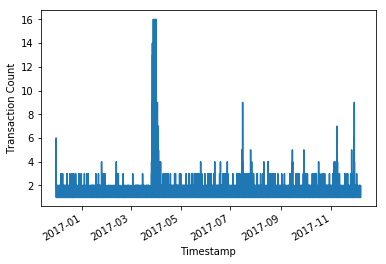

In [29]:
# Time series of the number of transactions (daily) 
ts_transactions = df.groupby(['Timestamp']).size()
plt.ylabel('Transaction Count')
ts_transactions.plot()

**1-st assumption of MBG/NBD model: the time between transactions is distributed exponential with transaction rate $\lambda$. **

**Conclusion: The assumption doesn't hold, as we can see from the graph, the transactions have seasonality.**

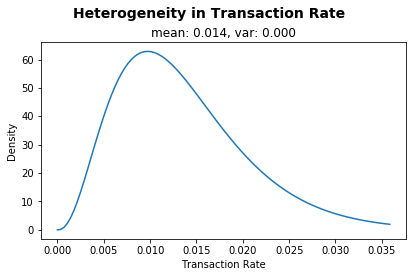

In [30]:
plot_transaction_rate_heterogeneity(mbg)

**2-nd assumption of MBG/NBD model: heterogeneity in $\lambda$ follows a gamma distribution with parameters $r$ and $\alpha$.**

**Conclusion: Not sure.**

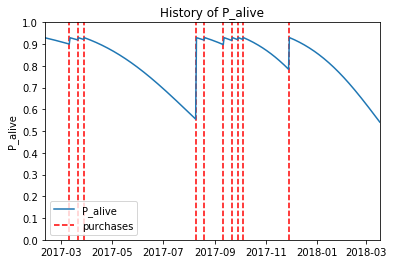

In [31]:
# Given a customer transaction history, we can calculate their historical probability of being alive,
# according to our trained model.
id = '60c19a709e3ced2d16d7100eb1069df5'
days_since_birth = 400
sp_trans = df.loc[df['CustomerID'] == id]
plot_history_alive(mbg, days_since_birth, sp_trans, 'Timestamp')

**The 3rd assumption of MBG/NBD model: after any transaction, a customer becomes inactive with probability $p$.**

**Conclusion: I think the assumption is valid.**

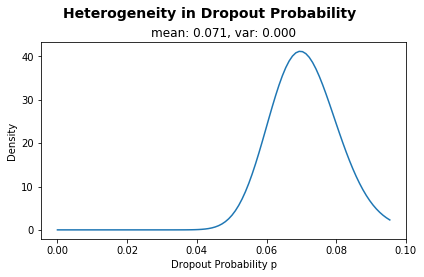

In [32]:
plot_dropout_rate_heterogeneity(mbg)

**4-th assumption of MBG/NBD model: heterogeneity in p follows a beta distribution.**

**Conclusion: Not sure. **

In [33]:
# check Pearson correlation between the two vectors is close to 0 in order to use this model.
returning_customers_summary[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.042791
frequency,0.042791,1.000000


**1-st assumption of the Gamma-Gamma model: there is no relationship between the monetary value and the purchase frequency.**

**Conclusion: The assumption holds, there is almost no linear correlation between the monetary valuess and frequency. **

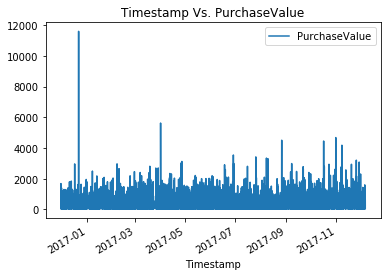

In [34]:
# df.plot('Timestamp', 'PurchaseValue')
purchase_value_vs_time = df[['PurchaseValue', 'Timestamp']].set_index('Timestamp')
purchase_value_vs_time.plot(title='Timestamp Vs. PurchaseValue')

**2-nd assumption of the Gamma-Gamma model: average transaction values vary across customers but do not vary over time for any given individual.**

**Conclusion: Not sure. **

In [35]:
df_temp = df[['CustomerID', 'PurchaseValue']].groupby(['CustomerID']).agg(['mean', 'count'])
# flatten hierarchical index
df_temp.columns = ['_'.join(col).strip() for col in df_temp.columns.values]
# compute correlation between average transaction values and transaction count
df_temp[['PurchaseValue_mean', 'PurchaseValue_count']].corr()

,PurchaseValue_mean,PurchaseValue_count
PurchaseValue_mean,1.000000,0.017653
PurchaseValue_count,0.017653,1.000000


**3-rd assumption of the Gamma-Gamma model: The distribution of average transaction values across customers is independent of the transaction process.**

**Conclusion: The assumption holds as we don't see little correlation between average transaction values and transaction process.**

### 5. Sample Data Generation
###### Instruction: generate a random sample of 100 customers and simulate the total number of purchases and total number of customers alive expected after 10 days, 1 year, 10 years and 100 years. Explain how you generated your sample and why you chose this method. For this section, you will need to write code beyond what is available in the lifetimes package.

###### Basic Ideas to Generate Random Samples:
1. Use pre-defined parameters, $r$ and $\alpha$, to construct a gamma distribution, and draw random samples from it to use as transaction rate $\lambda$ for each customer.
2. Use pre-defined parameters, $a$ and $b$, to construct a beta distribution, and draw random samples from it to use as drop out probability $p$ after each transaction for each customer.
3. Simulate transactions (without monetary value) based on its transaction rate with a dropout rate $p$ after each transaction (including immediately after the first purchase).

In [36]:
from numpy import random
# set random seed
random.seed(8888)

###### Simulating a Poisson process at rate λ up to time T:
1. t = 0, records = []
2. Generate U
3. Generate alive
4. t = t + [−(1/λ) ln (U)]. If t > T and alive, then stop
5. Append t to records
6. Go back to 2

In [37]:
def transactions_up_to_time(T, lambda_, p):
    """
    Generate artificial data by the poisson process.
    
    Parameters
    ----------
    T: int
        Observation window.
    lambda_: float
        Transaction rate.
    p: int
        Dropout rate.
    ----------
    
    Return
    ----------
    array:
        A list of timestamps for each transaction.
    int:
        Whether the person is still alive at the end of observatio period.
    ----------
    """
    
    t = 0
    records = []
    
    U = np.random.uniform(0,1)
    t = t -(1.0 / lambda_) * math.log(U)
    
    # simulate the drop out probability after 1st transaction
    alive = random.random() > p
    
    while (t <= T) and alive:
        records.append(t)
        
        U = np.random.uniform(0,1)
        t = t + (-(1.0 / lambda_) * math.log(U))
        
        alive = random.random() > p
    
    return records, alive

In [38]:
def transaction_times_before_death(p):
    """
    Generate the max number of transactions from a geometric distribution.
    
    Parameters
    ----------
    p: float
        Drop out rate.
    ----------
    
    Return
    ----------
    int
        Max number of transactions for a person.
    ----------
    """
    return np.random.geometric(p)


In [39]:
def drop_out_probability(a,b):
    """
    Generate drop out probability from a beta distribution.
    
    Parameters
    ----------
    a, b: float
        Parameters for a beta distribution.
    ----------
    
    Return
    ----------
    float
        Drop out probability after each purchase.
    ----------
    """
    return np.random.beta(a, b)

In [40]:
def transaction_rate(r, alpha):
    """
    Generate transaction rate from a gamma distribution.
    
    Parameters
    ----------
    r, alpha: float
        Parameters for a gamma distribution.
    ----------
    
    Return
    ----------
    float
        Transaction rate for a person.
    ----------
    """
    return np.random.gamma(r, scale = 1.0 / alpha)

###### Simulation Ideas:
1. Given observation window $T$, generate transaction records using poission process haivng observation window $T$, denoted as ${T_1, T_2, T_3, ..., T_n}$, n is the number of transactions during the observation period.
2. Determine the max number of transactions, $t_{max}$, a person can have during its lifetime based on a geometric distribution.
3. Define number of transactions to be $\min\{n, t_{max}\}$.
5. Accumulate the number of transactions and the number of customers alive.
6. Repeat step 1 to step 5 for 1000 rounds.
7. Calculate expected values.

In [41]:
def simulate(a, b, r, alpha, size, T_arr, round_):
    """
    Simulate the total number of purchases and total number of customers alive expected after certain time.
    
    Parameters
    ----------
    a, b: float
        Parameters for a beta distribution.
    r, alpha: float
        Parameters for a gamma distribution.
    size: int
        Number of customers.
    T_arr: array
        List of differnt time periods.
    round_: int
        Number of iteration.
    ----------
    """
    records = []
    
    transactions_total = 0
    alive_total = 0
    
    for T in T_arr:
        for epoch in range(round_):
            for i in range(size):
                p = drop_out_probability(a, b)
                lambda_ = transaction_rate(r, alpha)
                
                records, alive = transactions_up_to_time(T, lambda_, p)
                transaction_times_life = transaction_times_before_death(p)
                
                transactions_count = min(len(records), transaction_times_life)
                
                transactions_total += transactions_count
                alive_total += alive
        
        # compute expected values
        expected_transactions = transactions_total / round_
        expected_alive = alive_total / round_
        
        # clear counters
        transactions_total = 0
        alive_total = 0
        
        print("-----------------Observation Period: " + str(T) + " days-----------------")
        print("expected total number of purchases: ", expected_transactions)
        print("expected total number of customers alive: ", expected_alive)
        print()

In [42]:
a = 1.0
b = 2.0
r = 0.79
alpha = 85.27
size = 100
T_arr = [10 * 1, 365 * 1, 365 * 10, 365 * 100]
round_ = 1000

simulate(a, b, r, alpha, size, T_arr, round_)

-----------------Observation Period: 10 days-----------------
expected total number of purchases:  5.8
expected total number of customers alive:  65.231

-----------------Observation Period: 365 days-----------------
expected total number of purchases:  107.998
expected total number of customers alive:  41.768

-----------------Observation Period: 3650 days-----------------
expected total number of purchases:  287.866
expected total number of customers alive:  15.502

-----------------Observation Period: 36500 days-----------------
expected total number of purchases:  513.294
expected total number of customers alive:  3.649



### 6. Model Evaluation
###### Instruction: The model works well in some ways and poorly in others for the data we provide. Explain what it does a well and what it does poorly.

With transactional data, we can partition the dataset into a calibration period dataset and a holdout dataset. This is important as we want to test how our model performs on data not yet seen (just like cross-validation in standard machine learning literature). 

In [43]:
# date range of the dataset:
print("begin: ", df['Timestamp'].min())
print("end: ", df['Timestamp'].max())

begin:  2016-11-30 04:47:00
end:  2017-12-06 17:53:00


In [44]:
# use half of the data to train the model and half of the data to test the model
# resample the data by the unit of day
summary_cal_holdout = calibration_and_holdout_data(df, 'CustomerID', 'Timestamp',
                                                    calibration_period_end=pd.to_datetime('2017-06-01'),
                                                    observation_period_end=pd.to_datetime('2017-12-06'),
                                                    freq='D')

In [45]:
summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
CustomerID,,,,,
0001117ff1305c1fe840697166e61564,1.0,11.0,156.0,0.0,188
00028502859fd7e111d88c20456b59d5,0.0,0.0,154.0,0.0,188
0003f3458a6e7b495a975c2d9ddda559,1.0,2.0,155.0,1.0,188
000784b838b807ad589d4bc69c0c562f,0.0,0.0,22.0,0.0,188
000ad0f90e9fcb6ff5a0bc480cccbdb3,1.0,4.0,12.0,4.0,188


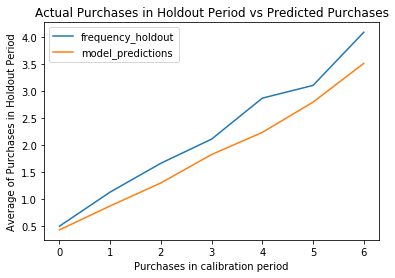

In [46]:
mbg.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(mbg, summary_cal_holdout)

###### Conclusion 1: The MBG/NBD model works pretty well when the purchase frequency is low. But it is not so good when the purchases frequency is high.

In [47]:
# in this case, we resample the data by the unit of week
summary_cal_holdout_w = calibration_and_holdout_data(df, 'CustomerID', 'Timestamp',
                                        calibration_period_end=pd.to_datetime('2017-06-01'),
                                        observation_period_end=pd.to_datetime('2017-12-06'),
                                        freq='W')

In [48]:
summary_cal_holdout_w.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
CustomerID,,,,,
0001117ff1305c1fe840697166e61564,1.0,1.0,22.0,0.0,27
00028502859fd7e111d88c20456b59d5,0.0,0.0,22.0,0.0,27
0003f3458a6e7b495a975c2d9ddda559,0.0,0.0,22.0,1.0,27
000784b838b807ad589d4bc69c0c562f,0.0,0.0,3.0,0.0,27
000ad0f90e9fcb6ff5a0bc480cccbdb3,1.0,1.0,2.0,3.0,27


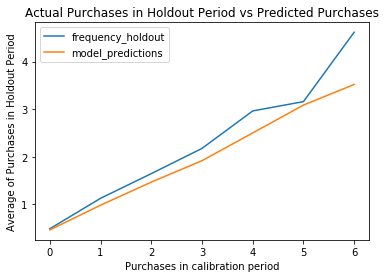

In [49]:
mbg.fit(summary_cal_holdout_w['frequency_cal'], summary_cal_holdout_w['recency_cal'], summary_cal_holdout_w['T_cal'], )
plot_calibration_purchases_vs_holdout_purchases(mbg, summary_cal_holdout_w)

###### Conclusion 2: The MBG/NBD model perform better when predicting weekly repeat purchases.

In [50]:
# try to change the calibration period
summary_cal_holdout_2 = calibration_and_holdout_data(df, 'CustomerID', 'Timestamp',
                                        calibration_period_end=pd.to_datetime('2017-09-01'),
                                        observation_period_end=pd.to_datetime('2017-12-06'),
                                        freq='W')

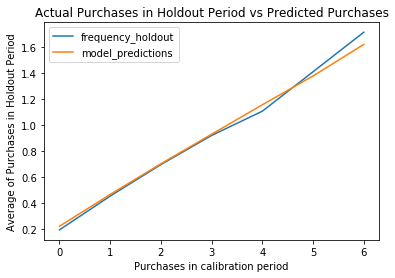

In [51]:
mbg.fit(summary_cal_holdout_2['frequency_cal'], summary_cal_holdout_2['recency_cal'], summary_cal_holdout_2['T_cal'], )
plot_calibration_purchases_vs_holdout_purchases(mbg, summary_cal_holdout_2)

###### As we can see from the graph, the model performs extremely well during the holdout period.
###### Conclusion 3: How to set the calibration and holdout periods matter for the MBG/NBD model.
###### Conclusion 4: The MBG/NBD model can only catch the normal purchasing behaviors and it is insensitive to seasonality (e.g. promotions).

### 7. Model Improvement
###### Instruction: The model works well in some ways and poorly in others for the data we provide. Explain what it does a well and what it does poorly.

###### Ideas: to conquer the deficiency of low predicion accuracy for high purchase frequency, we might want to cluster the customer into three categories (low, medium, high purchase frequency). And train 3 models seperately to predict customer purchases in the different categories. 

### 8. Classification Algorithms Evaluation
###### Suppose the intended use of the model is binning customers into one of the following categories: highly likely to purchase in the next year, somewhat likely to purchase in the next year, unlikely to purchase in the next year, highly unlikely to purchase in the next year. Suppose you want to compare this model with a model your colleague is proposing. How would you evaluate the two models? Do not implement, but do show a mockup of the results of your evaluation.

There are several ideas I can think of:
1. Train/test split. Split the dataset into two pieces, so that the model can be trained and tested on different data.
2. Confusion matrix. Compare metrics, such as, accuracy, misclassification rate, true positive rate, false positive rate, true negative rate, and precision.
3. AUC - ROC Curves. It tells how much model is capable of distinguishing between classes. Higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s.

### Confusion Matrix
Confusion matrix allows us to compare common metrics, such as, accuracy, misclassification rate, true positive rate, false positive rate, true negative rate, and precision. In this case, we will generate multi-class confusion matrix. e.g.

| | Predicted: highly likely | Predicted: somewhat likely | Predicted: unlikely | Predicted: highly unlikely
| --- | --- | --- | --- | --- |
| Actual: highly likely | a | b | c | d
| Actual: somewhat likely | a | b | c | d
| Actual: unlikely | a | b | c | d
| Actual: highly unlikely | a | b | c | d


### AUC - ROC Curves
AUC-ROC Curves tell how much model is capable of distinguishing between classes. Higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s. We can generate multi-class AUC-ROC curves to compare two models. Just like the picutures showing below.
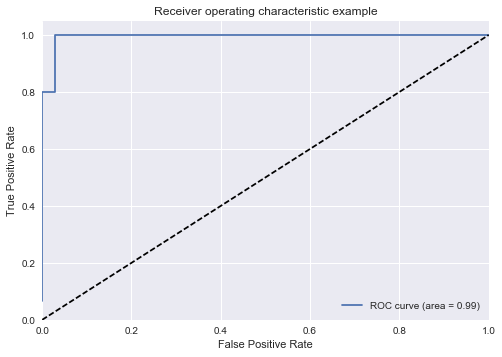
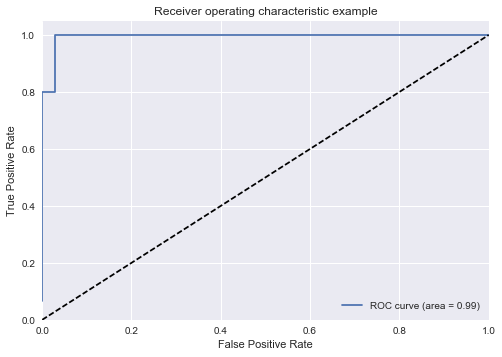
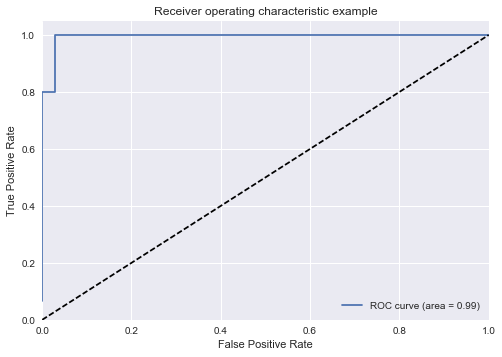

### References
1. oreilly-intro-to-predictive-clv. (https://github.com/datascienceinc/oreilly-intro-to-predictive-clv/)
2. Lifetime value in Python. (https://github.com/CamDavidsonPilon/lifetimes/)
3. '"Counting Your Customers" the Easy Way: An Alternative to the Pareto/NBD Model' (http://brucehardie.com/papers/bgnbd_2004-04-20.pdf)
4. Batislam, E.P., M. Denizel, A. Filiztekin (2007), "Empirical validation and comparison of models for customer base analysis," International Journal of Research in Marketing, 24 (3), 201-209. (https://www.sciencedirect.com/science/article/pii/S0167811607000171)
5. Poisson processes, and Compound (batch) Poisson processes. (http://www.columbia.edu/~ks20/4703-Sigman/4703-07-Notes-PP-NSPP.pdf)
6. Evaluating a Classification Model. (https://www.ritchieng.com/machine-learning-evaluate-classification-model/)
7. Sklearn: ROC for multiclass classification. (https://stackoverflow.com/questions/45332410/sklearn-roc-for-multiclass-classification)